In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm,truncexpon,norm,poisson
from resample import jackknife,bootstrap
from random import choices
from iminuit import Minuit,cost
from tqdm import tqdm

## Q1

In [13]:
np.random.seed(42)
n=10
x= norm.rvs(10,3,n)
x

array([11.49014246,  9.5852071 , 11.94306561, 14.56908957,  9.29753988,
        9.29758913, 14.73763845, 12.30230419,  8.59157684, 11.62768013])

In [14]:
print(jackknife.bias_corrected(np.var,x),np.var(x),np.var(x,ddof=1))

4.704669452131576 4.23420250691841 4.704669452131567


## Q2

In [15]:
mu= 5
sig= 0.5
lam= 2
x_max= 20
x_min=1
N_s= 800
N_b= 5000
f= 0.1

In [16]:
def sgnl(mu,sig):
    a= (x_min-mu)/sig 
    b= (x_max-mu)/sig
    return truncnorm(a=a,b=b,loc=mu,scale=sig)

def test_bkg(lam):
    c= (x_max-x_min)*lam
    return truncexpon(b=c,loc=x_min,scale=1/lam)

def real_bkg_pdf(x,lam):
    N= (x_max**(1-lam)-x_min**(1-lam))/(1-lam)
    return np.where((x_min<=x)&(x<=x_max),x**-lam/N,0)


def test_dist_pdf(x,N_s,mu,sig,N_b,lam):
    return N_s*sgnl(mu,sig).pdf(x)+ N_b*test_bkg(lam).pdf(x)

def test_dist_density(x,N_s,mu,sig,N_b,lam):
    return N_s+N_b,test_dist_pdf(x,N_s,mu,sig,N_b,lam)

def real_dist_pdf(x,N_s,mu,sig,N_b,lam):
    a= (x_min-mu)/sig 
    b= (x_max-mu)/sig
    return N_s*sgnl(mu,sig).pdf(x)+ N_b*real_bkg_pdf(x,lam)

def real_dist_density(x,N_s,mu,sig,N_b,lam):
    return N_s+N_b, real_dist_pdf(x,N_s,mu,sig,N_b,lam)




In [17]:
def accept_reject(func,range,fmax,size,*args):
        samples= []
        i=0

        while len(samples)<size:
                x= np.random.uniform(*range)
                f_val= func(x,*args)
                accept= choices([True,False],[f_val/fmax,1-f_val/fmax])[0]
                #f_rand= np.random.uniform(0,fmax)
                #if f_rand < f_val :
                if accept:
                        samples.append(x)
                
                i+=1
        
        print(f"Found {len(samples)} samples in {i} iterations")

        
        return np.array(samples)
    

In [18]:
#Generating data
bkg_samples= accept_reject(real_bkg_pdf,(x_min,x_max),x_min**-lam,poisson.rvs(N_b),lam)
sgnl_samples= sgnl(mu,sig).rvs(poisson.rvs(N_s))
X= np.concat((bkg_samples,sgnl_samples))
X[np.random.choice(len(X),len(X),replace=False)]
len(X)

Found 4927 samples in 95517 iterations


5738

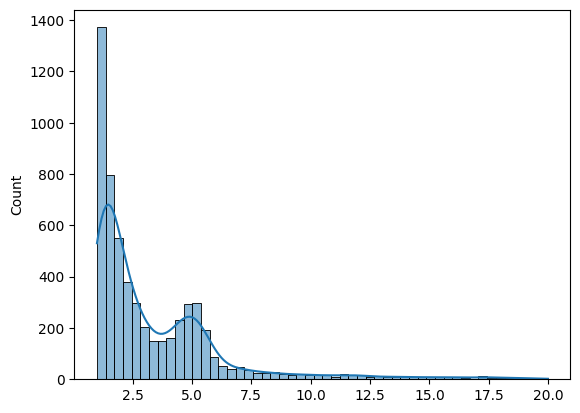

In [19]:
#Interesting to see how the kde gets affected at physical boundaries, Best to extend the data or truncate the kde 
sns.histplot(X,kde=True)
plt.show()

In [20]:
enll= cost.ExtendedUnbinnedNLL(X,test_dist_density)
mi= Minuit(enll,N_s=N_s,mu=mu,sig=sig,N_b=N_b,lam=lam)
mi.migrad()
mi.hesse()
mi.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6.664e+04                 │             Nfcn = 1419              │
│ EDM = 2.31e-05 (Goal: 0.0002)    │            time = 3.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_s  │    420    │    35     │    -34     │     35     │         │         │       │
│ 1 │ mu   │   5.074   │   0.031   │   -0.031   │   0.031    │         │         │       │
│ 2 │ sig  │   0.335   │   0.024   │   -0.023   │   0.024    │         │         │       │
│ 3 │ N_b  │  5.32e3   │  0.08e3   │  -0.08e3   │   0.08e3   │         │         │       │
│ 4 │ lam  │   0.443   │   0.006   │   -0.006   │   0.006    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          N_s          │          mu           │          sig          │          N_b          │          lam          │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -34    │    35     │  -0.031   │   0.031   │  -0.023   │   0.024   │    -80    │    80     │  -0.006   │   0.006   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌─────┬───────────────────────────────────────────────────┐
│     │       N_s        mu       sig       N_b       lam │
├─────┼───────────────────────────────────────────────────┤
│ N_s │   1.2e+03 -140.9e-3  311.0e-3    -0.8e3  51.29e-3 │
│  mu │ -140.9e-3  0.000954   -0.1e-3  140.9e-3         0 │
│ sig │  311.0e-3   -0.1e-3  0.000559 -311.0e-3   0.02e-3 │
│ N_b │    -0.8e3  140.9e-3 -311.0e-3   6.1e+03 -51.29e-3 │
│ lam │  51.29e-3         0   0.02e-3 -51.29e-3  4.11e-05 │
└─────┴───────────────────────────────────────────────────┘

In [21]:
og_mu= mi.values.to_dict()['mu']

In [27]:
jck_mus=[]
#X_jck= jackknife.resample(X)
m= 30
N=len(X)
J= N//m

for i in tqdm(range(J)):

    X_j= X[~np.isin(np.arange(N),np.arange(m*i,m*(i+1)))]
    enll= cost.ExtendedUnbinnedNLL(X_j,test_dist_density)
    mi= Minuit(enll,N_s=N_s,mu=mu,sig=sig,N_b=N_b,lam=lam)
    jck_mus.append(mi.migrad().values.to_dict()['mu'])

bias_corrected_mu= J*og_mu - (J-1)*np.mean(jck_mus)



100%|██████████| 191/191 [06:46<00:00,  2.13s/it]


In [209]:
enll= cost.ExtendedUnbinnedNLL(X,real_dist_density)
mi= Minuit(enll,N_s=N_s,mu=mu,sig=sig,N_b=N_b,lam=lam)
mi.migrad()
mi.hesse()
mi.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6.78e+04                  │              Nfcn = 399              │
│ EDM = 6.66e-06 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_s  │    770    │    40     │    -40     │     40     │         │         │       │
│ 1 │ mu   │   5.038   │   0.026   │   -0.026   │   0.026    │         │         │       │
│ 2 │ sig  │   0.472   │   0.023   │   -0.023   │   0.024    │         │         │       │
│ 3 │ N_b  │  4.97e3   │  0.08e3   │  -0.08e3   │   0.08e3   │         │         │       │
│ 4 │ lam  │   2.010   │   0.022   │   -0.022   │   0.022    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          N_s          │          mu           │          sig          │          N_b          │          lam          │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -40    │    40     │  -0.026   │   0.026   │  -0.023   │   0.024   │    -80    │    80     │  -0.022   │   0.022   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌─────┬───────────────────────────────────────────────────┐
│     │       N_s        mu       sig       N_b       lam │
├─────┼───────────────────────────────────────────────────┤
│ N_s │   1.5e+03 -151.7e-3  340.9e-3    -0.7e3  214.0e-3 │
│  mu │ -151.7e-3  0.000665   -0.1e-3  151.6e-3        -0 │
│ sig │  340.9e-3   -0.1e-3  0.000538 -340.9e-3    0.1e-3 │
│ N_b │    -0.7e3  151.6e-3 -340.9e-3  5.69e+03 -214.0e-3 │
│ lam │  214.0e-3        -0    0.1e-3 -214.0e-3  0.000468 │
└─────┴───────────────────────────────────────────────────┘

In [28]:
real_fit_mu= mi.values.to_dict()['mu'] 
print(og_mu,real_fit_mu,bias_corrected_mu)

5.074145926089075 5.081678503390528 5.087661609639667


## Q3

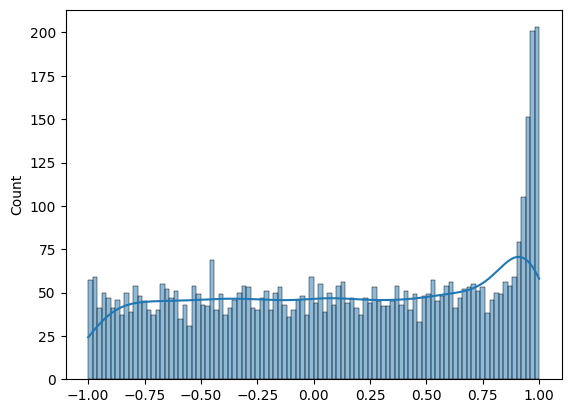

In [33]:
X= np.load('kaon.npy')
sns.histplot(X,kde=True,bins=100)
plt.show()

## Q4

In [5]:
X= np.load('peaking.npy')
X.shape

(10000,)

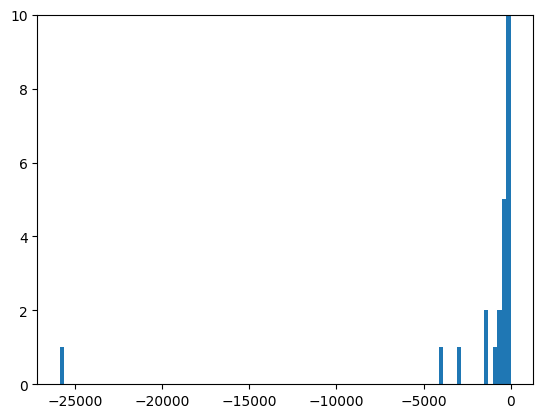

In [6]:
plt.hist(X,bins=100)
plt.ylim(0,10)
plt.show()

In [17]:
def one_norm(x,mu,sig,N_b):
    return N_b*norm(mu,sig).pdf(x)


def two_norm(x,mu,sig,mu2,sig2,N_s,N_b):
    #pdf=0
    #for mu,sig in zip(mus,sigs):
        #pdf+= norm(mu,sig).pdf(x)
    #return pdf

    return N_s*norm(mu,sig).pdf(x)+ N_b*norm(mu2,sig2).pdf(x)

In [15]:
nll= cost.UnbinnedNLL(X,one_norm)
mi= Minuit(nll,mu=-100,sig=100,N_b=len(X))
mi.fixed['N_b']= len(X)
mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -9.514e+04                 │              Nfcn = 217              │
│ EDM = 1.21e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   2.91    │   0.10    │            │            │         │         │       │
│ 1 │ sig  │   10.18   │   0.07    │            │            │         │         │       │
│ 2 │ N_b  │  10.0e3   │   0.1e3   │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────┐
│     │      mu     sig     N_b │
├─────┼─────────────────────────┤
│  mu │  0.0104   0.000    0.00 │
│ sig │   0.000 0.00519   0.000 │
│ N_b │    0.00   0.000       0 │
└─────┴─────────────────────────┘

In [18]:
nll= cost.UnbinnedNLL(X,two_norm)
mi= Minuit(nll,mu=-100,sig=100,mu2=25000,sig2=100,N_s=6000,N_b=4000)
mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.359e+04                 │              Nfcn = 412              │
│ EDM = 2.52e+04 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │  4.518e1  │  0.000e1  │            │            │         │         │       │
│ 1 │ sig  │ 1.1071e2  │ 0.0000e2  │            │            │         │         │       │
│ 2 │ mu2  │   2.5e4   │   0.0e4   │            │            │         │         │       │
│ 3 │ sig2 │    1e2    │    0e2    │            │            │         │         │       │
│ 4 │ N_s  │ 1.4539e4  │ 0.0000e4  │            │            │         │         │       │
│ 5 │ N_b  │    4e3    │    0e3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘